In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
## This is what chatGPT produced. I recreated my own code to learn better, but this could be a good reference.
# import numpy as np

# def value_iteration_for_gamblers(p_h, theta=0.000001, discount_factor=1.0):
#     """
#     Args:
#     p_h: Probability of the coin coming up heads
#     theta: Threshold used for value iteration
#     discount_factor: MDP discount factor.

#     Returns:
#     A tuple (policy, value_function).
#     """
#     def one_step_lookahead(s, V, rewards):
#         """
#         Helper function to calculate the value for all actions in a given state.
#         """
#         A = np.zeros(101)
#         stakes = range(1, min(s, 100 - s) + 1)  # The possible stakes
#         for a in stakes:
#             # Win scenario
#             A[a] += p_h * (rewards[s + a] + discount_factor * V[s + a])
#             # Lose scenario
#             A[a] += (1 - p_h) * (rewards[s - a] + discount_factor * V[s - a])
#         return A

#     V = np.zeros(101)
#     rewards = np.zeros(101)
#     rewards[100] = 1
#     policy = np.zeros(101)

#     while True:
#         delta = 0
#         for s in range(1, 100):
#             A = one_step_lookahead(s, V, rewards)
#             best_action_value = np.max(A)
#             delta = max(delta, np.abs(best_action_value - V[s]))
#             V[s] = best_action_value
#         if delta < theta:
#             break

#     for s in range(1, 100):
#         A = one_step_lookahead(s, V, rewards)
#         best_action = np.argmax(A)
#         policy[s] = best_action

#     return policy, V

# p_h = 0.4
# policy, V = value_iteration_for_gamblers(p_h, theta=1e-50)

In [3]:
# states = range(100)
# plt.bar(states, V)
# plt.xlabel('Capital')
# plt.ylabel('Value Estimates')
# plt.show()

# # policy bar plot
# plt.bar(states, policy)

# Initializing parameters

In [100]:
# states
states = np.arange(0, 101)
# discount factor
gamma = 1
# probability of heads(success)
p_h = 0.4
# initialize value function
V = np.zeros(101)
V[100] = 1
# error threshold
epsilon = 1e-20
# initialize policy
policy = np.zeros(101).astype(int)

In [8]:
len(V), len(policy)

(101, 101)

# Initialzing building blocks
### - The reward function
### - The value function(recursive)
### - The action value function

In [154]:
# reward function
def reward(state):
    return 1 if state >= 100 else 0

# action value function
def q_pi(s, a, V, p_h):
    """
    Args:
    s: the current state
    a: the action to take
    V: the value function
    p_h: the probability of the coin coming up heads

    Returns:
    The value of the state-action pair
    """
    # ensure that the action is valid, and there is no overflow over 100
    a = min(a, s, 100 - s)
    # stakes = range(1, min(s, 100 - s) + 1)
    return p_h * (reward(s + a) + gamma * V[s + a]) + \
     (1 - p_h) * (reward(s - a) + gamma * V[s - a])

# value function
def v_pi(s, V, policy, p_h):
    """
    Args:
    state: the current state
    V: the value function
    p_h: the probability of the coin coming up heads

    Returns:
    The value of the state
    """

    return q_pi(s, policy[s], V, p_h)



In [228]:
# One sweep over the values where we update the value of each state based on the current policy
def value_sweeper(V, policy, p_h):

    new_V = V.copy()

    # notice that our range excludes the terminal state
    for i in range(len(new_V)-1):
        new_V[i] = q_pi(i, policy[i], new_V, p_h)
    
    return new_V

# policy evaluation - sweep over the values until convergence. This gives us the true value function for the current policy.
def policy_evaluation(policy, V, p_h, epsilon, verbose=False, max_iter=1e5):
    """
    Args:
    policy: the current policy
    V: the current value function
    p_h: the probability of the coin coming up heads
    epsilon: the error threshold

    Returns:
    The value function based on the given policy till convergence
    """
    i = 0
    while True:
        i += 1
        delta = 0
        new_V = value_sweeper(V, policy, p_h)
        delta = max(delta, np.abs(new_V - V).max())
        V = new_V
        if delta < epsilon or i > max_iter:
            break
    
    if verbose:
        print(f'policy evaluation converged after {i} iterations')
    
    return V

# policy improvement - given a value function and a policy, we can improve the policy by acting greedily with respect to the value function
def policy_improvement(V, policy, p_h):
    for s in range(1, 100):
        actions = range(1, min(s, 100 - s) + 1)
        policy[s] = actions[np.argmax([q_pi(s, a, V, p_h) for a in actions])]
    return policy

## Policy iteration - we alternate between policy evaluation and policy improvement until convergence

## Value iteration - we alternate between value sweeping and policy improvement until convergence

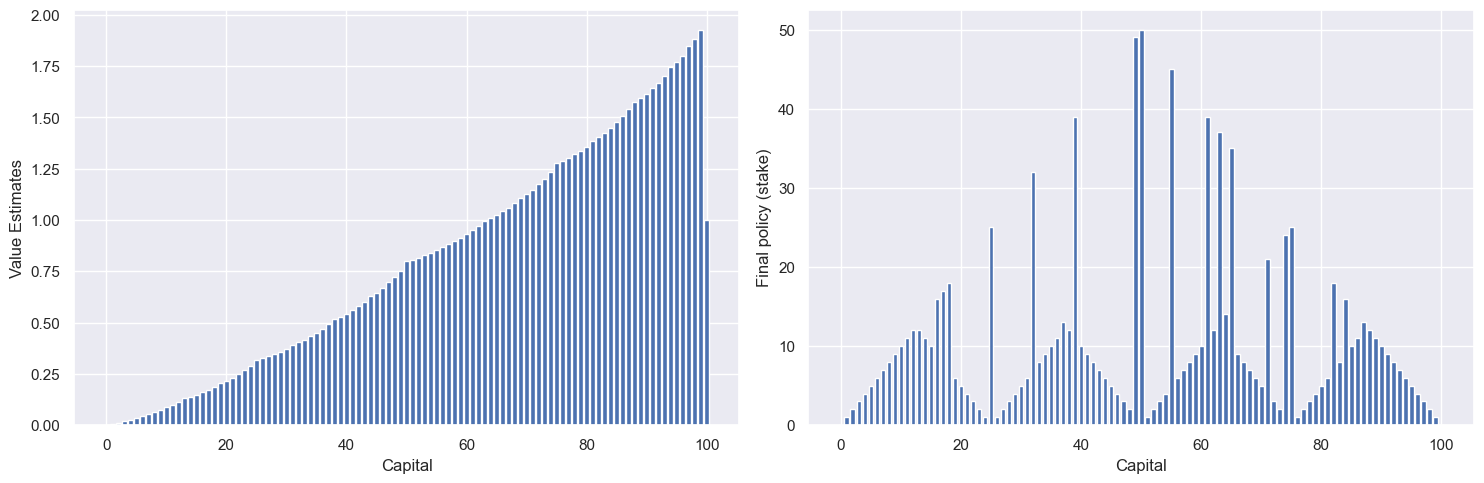

In [231]:
# Here, we will do one sweep over the values, and then greedily improve the policy. We will repeat this process until convergence. Only one sweep ensured by max_iter=1.

# Initialize values again, just to  be sure
V = np.zeros(101)
V[100] = 1
# policy where we bet min(s, 100-s)
# policy = (list(np.arange(50)) + list(np.arange(50, -1, -1)))
policy = np.zeros(101).astype(int)

for _ in range(100):
    # policy evaluation
    V = policy_evaluation(policy, V, p_h, epsilon, verbose=False, max_iter=1)
    # policy improvement
    policy = policy_improvement(V, policy, p_h)

# plot both
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(states, V)
plt.xlabel('Capital')
plt.ylabel('Value Estimates')
plt.subplot(1, 2, 2)
plt.bar(states, policy)
plt.xlabel('Capital')
plt.ylabel('Final policy (stake)')
plt.tight_layout()
plt.show()


We don't seem to have converged perfectly to the optimal policy, but we are close enough. Good job! Try to make a dashboard to visualize the value function and the policy.